In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os
import torch
import pickle
from torchvision import transforms
import numpy as np
from pathlib import Path
from PIL import Image
pd.options.mode.chained_assignment = None 

In [10]:
path = "../../Data/CUB_200_2011/"
path = Path(path)

image_path = path / "images"
attribute_path = path / "attributes"
segmentation_path = path / "segmentations"

# Smaller size for rescaling images
small_size = (244,244)

# Attribute Preprocessing

The original image_attribute_labels.txt contains some lines that contain too many columns and must therefore be cleaned.

In [11]:
lines = []

with open(attribute_path/"image_attribute_labels.txt") as file:
    for line in file:
        split_line = line.split()
        if len(split_line) > 5:
            del split_line[-2]
            line = " ".join(split_line)
        lines.append(line)

with open(attribute_path/"cleaned_image_attribute_labels.txt", 'w') as f:
    for line in lines:
        f.write(f"{line}\n")

In [12]:
attributes = pd.read_csv(attribute_path/"cleaned_image_attribute_labels.txt", delim_whitespace=True, header=None, names=["image_id", "attribute_id", "is_present", "certainty_id", "time"])
attributes

,image_id,attribute_id,is_present,certainty_id,time
0,1,1,0,3,27.708
1,1,2,0,3,27.708
2,1,3,0,3,27.708
3,1,4,0,3,27.708
4,1,5,1,3,27.708
...,...,...,...,...,...
3677851,11788,308,1,4,4.989
3677852,11788,309,0,4,8.309
3677853,11788,310,0,4,8.309
3677854,11788,311,0,4,8.309


Preparing the attributes for max voting, by setting the certainty to the given value if attribute is present and the negative value if the attribute is not present.

In [13]:
def attribute_df(attributes):
    rows = []
    for image_id in attributes.image_id.unique():
        id_attributes = attributes[attributes.image_id == image_id]
        id_attributes['certainty'] = 0
        id_attributes.certainty[id_attributes.is_present > 0] = id_attributes.certainty_id[id_attributes.is_present >0]
        id_attributes.certainty[id_attributes.is_present <= 0] = - id_attributes.certainty_id[id_attributes.is_present <=0]

        id_df = pd.DataFrame([image_id] + id_attributes.certainty.tolist())

        id_df = id_df.T
        id_df.columns = ['image_id'] + id_attributes.attribute_id.tolist()

        rows.append(id_df)
    rows = pd.concat(rows).set_index('image_id')
    return rows

In [14]:
df = attribute_df(attributes)
df.to_pickle(attribute_path/("attributes"".pkl"))
display(df)

,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
image_id,,,,,,,,,,,,,,,,,,,,,
1,-3,-3,-3,-3,3,-3,-3,-3,-3,-1,...,-4,-4,-4,-4,-4,4,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-4,...,-4,-4,-4,-4,-4,-4,-1,-1,-1,-1
3,-3,-3,-3,-3,3,-3,-3,-3,-3,-3,...,-3,-3,-3,-3,-3,3,-3,-3,3,-3
4,-4,-4,-4,-4,4,-4,-4,-4,-4,-4,...,-3,-3,-3,3,-3,-3,4,-4,-4,-4
5,-4,-4,-4,-4,4,-4,-4,-4,-4,-3,...,-4,-4,4,-4,-4,-4,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11784,-3,3,-3,-3,-3,-3,-3,-3,-3,-4,...,-3,-3,-3,3,-3,-3,3,-3,-3,-3
11785,-4,-4,-4,-4,-4,-4,4,-4,-4,-3,...,-3,-3,-3,3,-3,3,-1,-1,-1,-1
11786,-4,-4,-4,-4,-4,-4,4,-4,-4,-4,...,-4,-4,-4,-4,-4,4,-3,-3,3,-3


Creating attribute dict and attribute ranges.

In [16]:
attribute_dict = {}

with open(path/"../attributes.txt") as file:
    for line in file:
        split_line = line.split()
        attribute_id, attribute = split_line
        split_attribute = attribute.split("::")
        attr_class, value = split_attribute
        if attr_class in attribute_dict:
            attribute_dict[attr_class] += [(attribute_id, value)]
        else:
            attribute_dict[attr_class] = [(attribute_id, value)]
            
attribute_dict

{'has_bill_shape': [('1', 'curved_(up_or_down)'),
  ('2', 'dagger'),
  ('3', 'hooked'),
  ('4', 'needle'),
  ('5', 'hooked_seabird'),
  ('6', 'spatulate'),
  ('7', 'all-purpose'),
  ('8', 'cone'),
  ('9', 'specialized')],
 'has_wing_color': [('10', 'blue'),
  ('11', 'brown'),
  ('12', 'iridescent'),
  ('13', 'purple'),
  ('14', 'rufous'),
  ('15', 'grey'),
  ('16', 'yellow'),
  ('17', 'olive'),
  ('18', 'green'),
  ('19', 'pink'),
  ('20', 'orange'),
  ('21', 'black'),
  ('22', 'white'),
  ('23', 'red'),
  ('24', 'buff')],
 'has_upperparts_color': [('25', 'blue'),
  ('26', 'brown'),
  ('27', 'iridescent'),
  ('28', 'purple'),
  ('29', 'rufous'),
  ('30', 'grey'),
  ('31', 'yellow'),
  ('32', 'olive'),
  ('33', 'green'),
  ('34', 'pink'),
  ('35', 'orange'),
  ('36', 'black'),
  ('37', 'white'),
  ('38', 'red'),
  ('39', 'buff')],
 'has_underparts_color': [('40', 'blue'),
  ('41', 'brown'),
  ('42', 'iridescent'),
  ('43', 'purple'),
  ('44', 'rufous'),
  ('45', 'grey'),
  ('46', 'yello

In [17]:
ranges = {}
for attr_class, values in attribute_dict.items():
    r = [int(v[0]) for v in values]
    ranges[attr_class] = (min(r), max(r))
print(ranges)
pickle.dump(ranges, open( attribute_path/"attribute_ranges.pkl", "wb" ) )

{'has_bill_shape': (1, 9), 'has_wing_color': (10, 24), 'has_upperparts_color': (25, 39), 'has_underparts_color': (40, 54), 'has_breast_pattern': (55, 58), 'has_back_color': (59, 73), 'has_tail_shape': (74, 79), 'has_upper_tail_color': (80, 94), 'has_head_pattern': (95, 105), 'has_breast_color': (106, 120), 'has_throat_color': (121, 135), 'has_eye_color': (136, 149), 'has_bill_length': (150, 152), 'has_forehead_color': (153, 167), 'has_under_tail_color': (168, 182), 'has_nape_color': (183, 197), 'has_belly_color': (198, 212), 'has_wing_shape': (213, 217), 'has_size': (218, 222), 'has_shape': (223, 236), 'has_back_pattern': (237, 240), 'has_tail_pattern': (241, 244), 'has_belly_pattern': (245, 248), 'has_primary_color': (249, 263), 'has_leg_color': (264, 278), 'has_bill_color': (279, 293), 'has_crown_color': (294, 308), 'has_wing_pattern': (309, 312)}


Getting continuous attribute labels for max voting.

In [19]:
class_attribute_labels_continuous = pd.read_csv(attribute_path/"class_attribute_labels_continuous.txt", sep=" ", header=None, names = np.arange(1, 313))
images = pd.read_csv(path/"images.txt", sep=" ", header=None, names=["image_id", "filename"])
images['animal_class'] = images.apply(lambda row: row["filename"].split("/")[0], axis = 1)

In [22]:
animal_classes = []

with open(path/"classes.txt") as file:
    for line in file:
        split_line = line.split()
        animal_id, animal_class = split_line
        animal_classes.append(animal_class)
        
class_attribute_labels_continuous["animal_class"] = animal_classes
class_attribute_labels_continuous = class_attribute_labels_continuous.set_index("animal_class")
class_attribute_labels_continuous

,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
animal_class,,,,,,,,,,,,,,,,,,,,,
001.Black_footed_Albatross,0.000000,2.919708,1.459854,0.000000,59.854015,26.277372,3.649635,5.839416,0.000000,1.639344,...,0.000000,0.000000,21.276596,11.347518,2.12766,31.914894,53.571429,5.357143,21.428571,19.642857
002.Laysan_Albatross,4.411765,4.411765,2.941176,1.470588,57.352941,27.205882,0.000000,2.205882,0.000000,0.000000,...,0.000000,2.255639,2.255639,94.736842,0.00000,0.000000,77.142857,3.809524,10.476190,8.571429
003.Sooty_Albatross,0.000000,3.973510,3.311258,0.000000,70.860927,14.569536,5.298013,1.986755,0.000000,0.000000,...,2.205882,0.000000,38.970588,2.941176,0.00000,16.176471,71.028037,0.934579,7.476636,20.560748
004.Groove_billed_Ani,0.000000,1.459854,10.218978,0.000000,0.000000,0.000000,8.759124,25.547445,54.014599,5.839416,...,0.000000,0.000000,88.571429,0.000000,0.00000,2.142857,84.126984,2.380952,3.174603,10.317460
005.Crested_Auklet,0.000000,0.000000,3.225806,0.000000,1.075269,0.000000,0.000000,32.258065,63.440860,0.000000,...,0.000000,0.000000,82.727273,5.454545,0.00000,4.545455,88.461538,0.000000,3.846154,7.692308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196.House_Wren,2.702703,12.837838,0.000000,0.000000,0.000000,0.000000,76.351351,8.108108,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.973684,0.00000,29.605263,14.379085,22.875817,56.209150,6.535948
197.Marsh_Wren,18.300654,11.764706,0.000000,3.267974,0.000000,0.000000,60.784314,5.882353,0.000000,0.000000,...,0.000000,0.000000,35.443038,4.430380,0.00000,22.784810,16.783217,25.174825,32.167832,25.874126
198.Rock_Wren,10.759494,36.708861,0.000000,7.594937,0.632911,0.000000,43.670886,0.632911,0.000000,0.000000,...,0.000000,0.000000,14.375000,13.125000,0.00000,41.875000,18.791946,44.295302,18.791946,18.120805


In [24]:
def get_most_confident(animal_class, indices):
    indices = [i[0] for i in indices]
    certainties = class_attribute_labels_continuous.loc[animal_class,indices]
    return certainties.idxmax()

processed_attributes = pd.DataFrame(index=df.index)
one_hot = np.zeros((len(df), 312), dtype=np.uint8)
for attr_class, rnge in ranges.items():
    column = []
    range_df = df.loc[:,rnge[0]:rnge[1]]
    maxima = range_df.apply(lambda x: np.argwhere(x.to_numpy() == np.amax(x.to_numpy()))+rnge[0], axis=1)
    
    for i, m in enumerate(maxima):
        image_id = i+1
        if len(m) == 1:
            column.append(m[0,0]-rnge[0])
            one_hot[i, m[0,0]-1] = 1
        else:
            # get most probable from list
            animal_class = images[images.image_id == image_id].animal_class.values[0]
            most_confident = get_most_confident(animal_class, m)
            column.append(most_confident)
            one_hot[i, most_confident-1] = 1

    processed_attributes[attr_class] = column

np.save(path/f"attributes/one_hot_processed_attributes.npy", one_hot)
processed_attributes.to_pickle(attribute_path /"processed_attributes.pkl")  
processed_attributes

,has_bill_shape,has_wing_color,has_upperparts_color,has_underparts_color,has_breast_pattern,has_back_color,has_tail_shape,has_upper_tail_color,has_head_pattern,has_breast_color,...,has_size,has_shape,has_back_pattern,has_tail_pattern,has_belly_pattern,has_primary_color,has_leg_color,has_bill_color,has_crown_color,has_wing_pattern
image_id,,,,,,,,,,,,,,,,,,,,,
1,4,11,26,45,55,60,75,81,3,107,...,0,2,237,241,245,14,275,14,14,309
2,5,5,5,45,55,5,2,5,100,12,...,1,13,237,241,245,5,1,13,5,309
3,4,11,26,45,0,14,75,81,103,1,...,2,5,3,241,245,1,275,14,14,2
4,4,1,1,45,55,1,2,81,3,107,...,3,5,0,0,245,1,275,290,295,0
5,4,11,26,41,0,60,3,81,7,107,...,0,5,237,0,0,250,275,1,295,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11784,1,5,5,5,0,5,5,86,3,5,...,1,13,0,3,0,5,3,290,12,0
11785,6,11,39,6,0,73,2,86,98,6,...,4,13,237,0,0,6,278,290,308,309
11786,6,16,31,6,0,65,76,86,98,6,...,4,13,3,241,0,6,273,290,14,2


# Preprocessing the CUB dataset

Preprocessing the images for training. Please make sure that segmentation masks are in the folder `Data/CUB_200_2011/segmentations`. Segmentations can be downloaded here: https://data.caltech.edu/records/20097

In [25]:
class CUB_Image:
    def __init__(self, image_id, image, segmentation, attributes, filename):
        self.image_id = image_id
        self.image = image
        self.segmentation = segmentation
        self.attributes = attributes
        self.filename = filename

    @property
    def cropped(self):
        return np.einsum("ijk,ij->ijk", self.image, self.segmentation).astype(np.uint8)

    def attribute_list(self, min_certainty=3, present=True):
        if present:
            return self.attributes[(self.attributes.image_id == self.image_id) & (self.attributes.is_present > 0) & (self.attributes.certainty_id >= min_certainty)].attribute_id.tolist()
        else:
            return self.attributes[(self.attributes.image_id == self.image_id) & (self.attributes.is_present == 0) & (self.attributes.certainty_id >= min_certainty)].attribute_id.tolist()


In [34]:
with open(path / 'images.txt') as file:
    files = [(int(line.split(" ")[0]), Path(line.split(" ")[1])) for line in file]

attributes = pd.read_csv(attribute_path/"cleaned_image_attribute_labels.txt", delim_whitespace=True, header=None, names=["image_id", "attribute_id", "is_present", "certainty_id", "time"])
train_test = pd.read_csv(path / "train_test_split.txt", header=None, delim_whitespace=True, names=["image_id", "is_training_image"]).set_index('image_id')
train_test['is_training_image'] = train_test['is_training_image'].astype('bool')

def rescale(img, new_size=(500,500), color=(0,0,0)):
    width, height = img.size
    result = Image.new(img.mode, new_size, color)
    result.paste(img, ((new_size[0]-width)//2, (new_size[1] - height) // 2))
    return result

train_set = []
test_set = []

train_image_id_to_index = {}
train_index_to_image_id = {}

test_image_id_to_index = {}
test_index_to_image_id = {}

for image_id, filename in files:
    image = Image.open(image_path / filename.with_suffix('.jpg'))
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # making the image square
    image = rescale(image)

    segmentation = Image.open(segmentation_path / filename.with_suffix('.png'))
    if segmentation.mode != 'L':
        segmentation = segmentation.convert('L')
    segmentation = rescale(segmentation, color=0)

    # smaller size if needed
    image.thumbnail(small_size,Image.Resampling.LANCZOS)
    segmentation.thumbnail(small_size,Image.Resampling.LANCZOS)
    
    image = np.asarray(image)
    segmentation = np.asarray(segmentation)
    segmentation = segmentation / np.max(segmentation)

    img_attributes = attributes[attributes.image_id == image_id]

    cub = CUB_Image(image_id, image, segmentation, attributes, filename)

    if train_test.loc[image_id].is_training_image:
        index = len(train_set)
        train_image_id_to_index[image_id] = index
        train_index_to_image_id[index] = image_id
        train_set.append(cub.cropped)
    else:
        index = len(test_set)
        test_image_id_to_index[image_id] = index
        test_index_to_image_id[index] = image_id
        test_set.append(cub.cropped)

test_set = np.stack(test_set, axis=0)
train_set = np.stack(train_set, axis=0)

Saving all image information as numpy arrays and pickle.

In [39]:
data_path = path /f"{small_size[0]}x{small_size[1]}"
data_path.mkdir(exist_ok=True, parents=True)
filename = "CUB_200_2011"
np.save(data_path/f"{filename}_train.npy", train_set)
np.save(data_path/f"{filename}_test.npy", test_set)
pickle.dump( (attributes, train_image_id_to_index, train_index_to_image_id, test_image_id_to_index, test_index_to_image_id), open( data_path/f"{filename}.pkl", "wb" ) )

Example bird

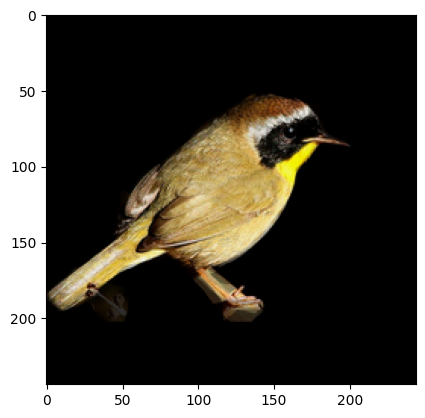

In [36]:
plt.imshow(train_set[-1])
plt.show()